# Analysis of Spatial Transcriptomics enrichment on BRICK

Compared with single-cell transcriptomics, spatial transcriptomics records the spatial location of each cell simultaneously. This enables the analysis of the characteristics of the spatial distribution of different cell types in tissues using spatial transcriptomics. Some biological functions and processes require the joint participation of multiple cell types within the tissue. BRICK can advance the analysis of spatial transcriptomics by querying the spatial relationships between cell tissues to identify cells that truly have anatomical spatial relationships.

## Loading Packages and Data

Here we take a Slide-seq mouse testis dataset as example. [\<Dissecting mammalian spermatogenesis using spatial transcriptomics\>](https://www.cell.com/cell-reports/fulltext/S2211-1247(21)01388-7?uuid=uuid%3Abf78c16a-4834-4054-83a5-aac5ffe8b8f3#sec-4)

In [3]:
#import squidpy as sq
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph database has been configured and initialized successfully.


/tmp/ipykernel_67/1715533570.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_wt, color='celltype', spot_size=30)


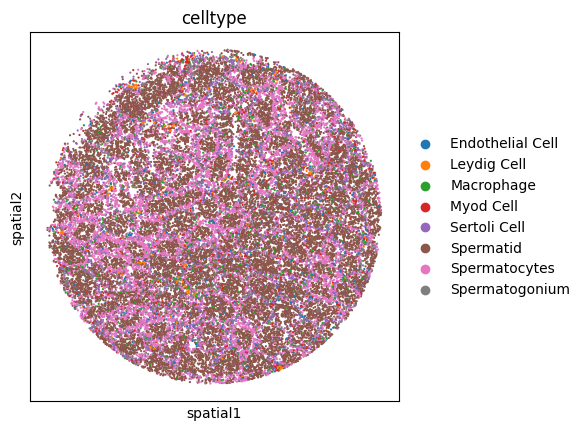

In [4]:
adata_wt = sc.read('/workspace/data/WT1_ct.h5ad')
sc.pl.spatial(adata_wt, color='celltype', spot_size=30)

## calculate Co-occurrence
Here we use the co-occurrence to study the spatial distribution of celltypes.

In [7]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import networkx as nx
import anndata
from sklearn.neighbors import KDTree
from anndata import AnnData
from collections import defaultdict
import time
from sklearn.metrics import pairwise_distances

def co_occurrence_plot(adata, use_col, groups=[], use_key = 'co-occur'):
    if len(groups)==0:
        groups = adata.uns[use_key].keys()
    nrow = int(np.sqrt(len(groups)))
    ncol = np.ceil(len(groups)/nrow).astype(int)
    print(nrow, ncol)
    
    
    fig = plt.figure(figsize=(3*ncol,3*nrow))
    axs = fig.subplots(nrow,ncol)
    
    clust_unique = list(adata.obs[use_col].astype('category').cat.categories)
    ct2color = dict(zip(clust_unique, adata.uns[f'{use_col}_colors']))
    
    for i, g in enumerate(groups):
        interest = adata.uns[use_key][g]
        if nrow == 1:
            if ncol == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[int(i/ncol)][(i%ncol)]
        for x in interest:
            ax.plot(interest[x], label = x, c=ct2color[x])
        ax.set_title(g)
        ax.legend(fontsize = 7, ncol = max(1, nrow-1), loc='upper right')
    #plt.show()
    return fig

def co_occurrence(adata, use_col, dist_thres=300, steps=10, genelist=None, gene_thresh=0):
    """Compute spatial co-occurrence of cell types using KDTree for radius queries."""
    # Get coordinates and cell type labels
    coords = adata.obsm['spatial']
    labels = adata.obs[use_col].values
    unique_labels = np.unique(labels)
    n_cells = len(labels)
    
    # Build KDTree for efficient radius queries
    tree = KDTree(coords, metric='euclidean')
    
    # Distance thresholds
    thresh = np.linspace(0, dist_thres, num=steps+1)
    
    # Initialize output dictionary: distance -> DataFrame of counts
    out = {}
    
    # If genelist is provided, process gene expression
    if genelist is not None:
        # Convert genelist to list of indices or names
        if isinstance(genelist, np.ndarray):
            genelist = list(genelist)
        elif isinstance(genelist, str):
            genelist = [genelist]
        elif isinstance(genelist, int):
            genelist = [genelist]
        
        # Get gene expression matrix
        if sparse.issparse(adata.X):
            gene_exp = adata[:, genelist].X.toarray()  # (n_cells, n_genes)
        else:
            gene_exp = adata[:, genelist].X.copy()     # (n_cells, n_genes)
        gene_exp[gene_exp < gene_thresh] = 0
        
        # For each distance threshold, count co-occurrence with genes
        for i in range(len(thresh)-1):
            r_min, r_max = thresh[i], thresh[i+1]
            # Query pairs within radius r_max but not within r_min
            # We'll query for r_max and then filter by r_min
            indices = tree.query_radius(coords, r=r_max, return_distance=False)
            counts = {label: 0 for label in unique_labels}
            cooccur = defaultdict(lambda: {gene: 0 for gene in genelist})
            
            for idx in range(n_cells):
                label = labels[idx]
                neighbors = indices[idx]
                # Filter by distance >= r_min using actual distances
                if r_min > 0:
                    dists = np.linalg.norm(coords[neighbors] - coords[idx], axis=1)
                    neighbors = neighbors[(dists >= r_min) & (dists < r_max)]
                else:
                    # For r_min=0, we already have dists < r_max
                    pass
                
                # Count gene co-occurrence
                for gene_idx, gene in enumerate(genelist):
                    if gene_exp[neighbors, gene_idx].sum() > 0:
                        cooccur[label][gene] += 1
                counts[label] += 1
            
            # Normalize by cell type counts
            df = pd.DataFrame(cooccur).T  # rows: labels, columns: genes
            for label in df.index:
                if counts[label] > 0:
                    df.loc[label] /= counts[label]
            out[r_max] = df
    else:
        # No genelist: compute cell type co-occurrence
        # Precompute label indices for faster lookup
        label_to_idx = {label: i for i, label in enumerate(unique_labels)}
        n_labels = len(unique_labels)
        
        # For each distance threshold
        for i in range(len(thresh)-1):
            r_min, r_max = thresh[i], thresh[i+1]
            # Initialize co-occurrence matrix
            cooccur = np.zeros((n_labels, n_labels), dtype=float)
            counts = np.zeros(n_labels, dtype=float)
            
            # Query radius r_max
            indices = tree.query_radius(coords, r=r_max, return_distance=False)
            
            for idx in range(n_cells):
                label_idx = label_to_idx[labels[idx]]
                neighbors = indices[idx]
                
                # Filter by distance >= r_min
                if r_min > 0:
                    dists = np.linalg.norm(coords[neighbors] - coords[idx], axis=1)
                    neighbors = neighbors[(dists >= r_min) & (dists < r_max)]
                
                # Get unique labels of neighbors
                if len(neighbors) > 0:
                    neighbor_labels = labels[neighbors]
                    unique_neighbor_labels = np.unique(neighbor_labels)
                    for nl in unique_neighbor_labels:
                        nl_idx = label_to_idx[nl]
                        cooccur[label_idx, nl_idx] += 1
                counts[label_idx] += 1
            
            # Normalize
            for j in range(n_labels):
                if counts[j] > 0:
                    cooccur[j, :] /= counts[j]
            
            # Convert to DataFrame
            df = pd.DataFrame(cooccur, index=unique_labels, columns=unique_labels)
            out[r_max] = df
    
    # Reformat to match notebook's output structure: dict of DataFrames per focal cell type
    ret = {}
    # Use the last threshold's DataFrame to get index (cell types)
    last_key = list(out.keys())[-1]
    for focal_label in out[last_key].index:
        tmp = {}
        for dist in out:
            tmp[dist] = out[dist].T[focal_label]
        ret[focal_label] = pd.DataFrame(tmp).T
    
    adata.uns['co-occur_our'] = ret
    return ret


def co_occurrence_heatmap(adata, use_col, dist_min=0, dist_max=10000, use_key = 'co-occur'):
    from seaborn import heatmap
    for tmp in adata.uns[use_key].values():
        break
    groups = [x for x in tmp.index if (x<dist_max)&(x>dist_min)]
    nrow = int(np.sqrt(len(groups)))
    ncol = np.ceil(len(groups)/nrow).astype(int)
    print(nrow, ncol)
    fig = plt.figure(figsize=(9*ncol,8*nrow))
    axs = fig.subplots(nrow,ncol)
    clust_unique = list(adata.obs[use_col].astype('category').cat.categories)
    for i, g in enumerate(groups):
        interest = pd.DataFrame({x:adata.uns[use_key][x].T[g] for x in adata.uns[use_key]})
        #interest = pd.DataFrame({x:adata.uns[use_key][x].T[g] for x in clust_unique})
        if nrow == 1:
            if ncol == 1:
                ax = axs
            else:
                ax = axs[i]
        else:
            ax = axs[int(i/ncol)][(i%ncol)]
        if set(interest.index)==set(clust_unique) and set(interest.columns)==set(clust_unique):
            interest = interest.loc[clust_unique, clust_unique]
        heatmap(interest, ax=ax)
        ax.set_title('{:.4g}'.format(g))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', va = 'top')
        #ax.legend(fontsize = 7, ncol = max(1, nrow-1), loc='upper right')
    plt.show()

3 4


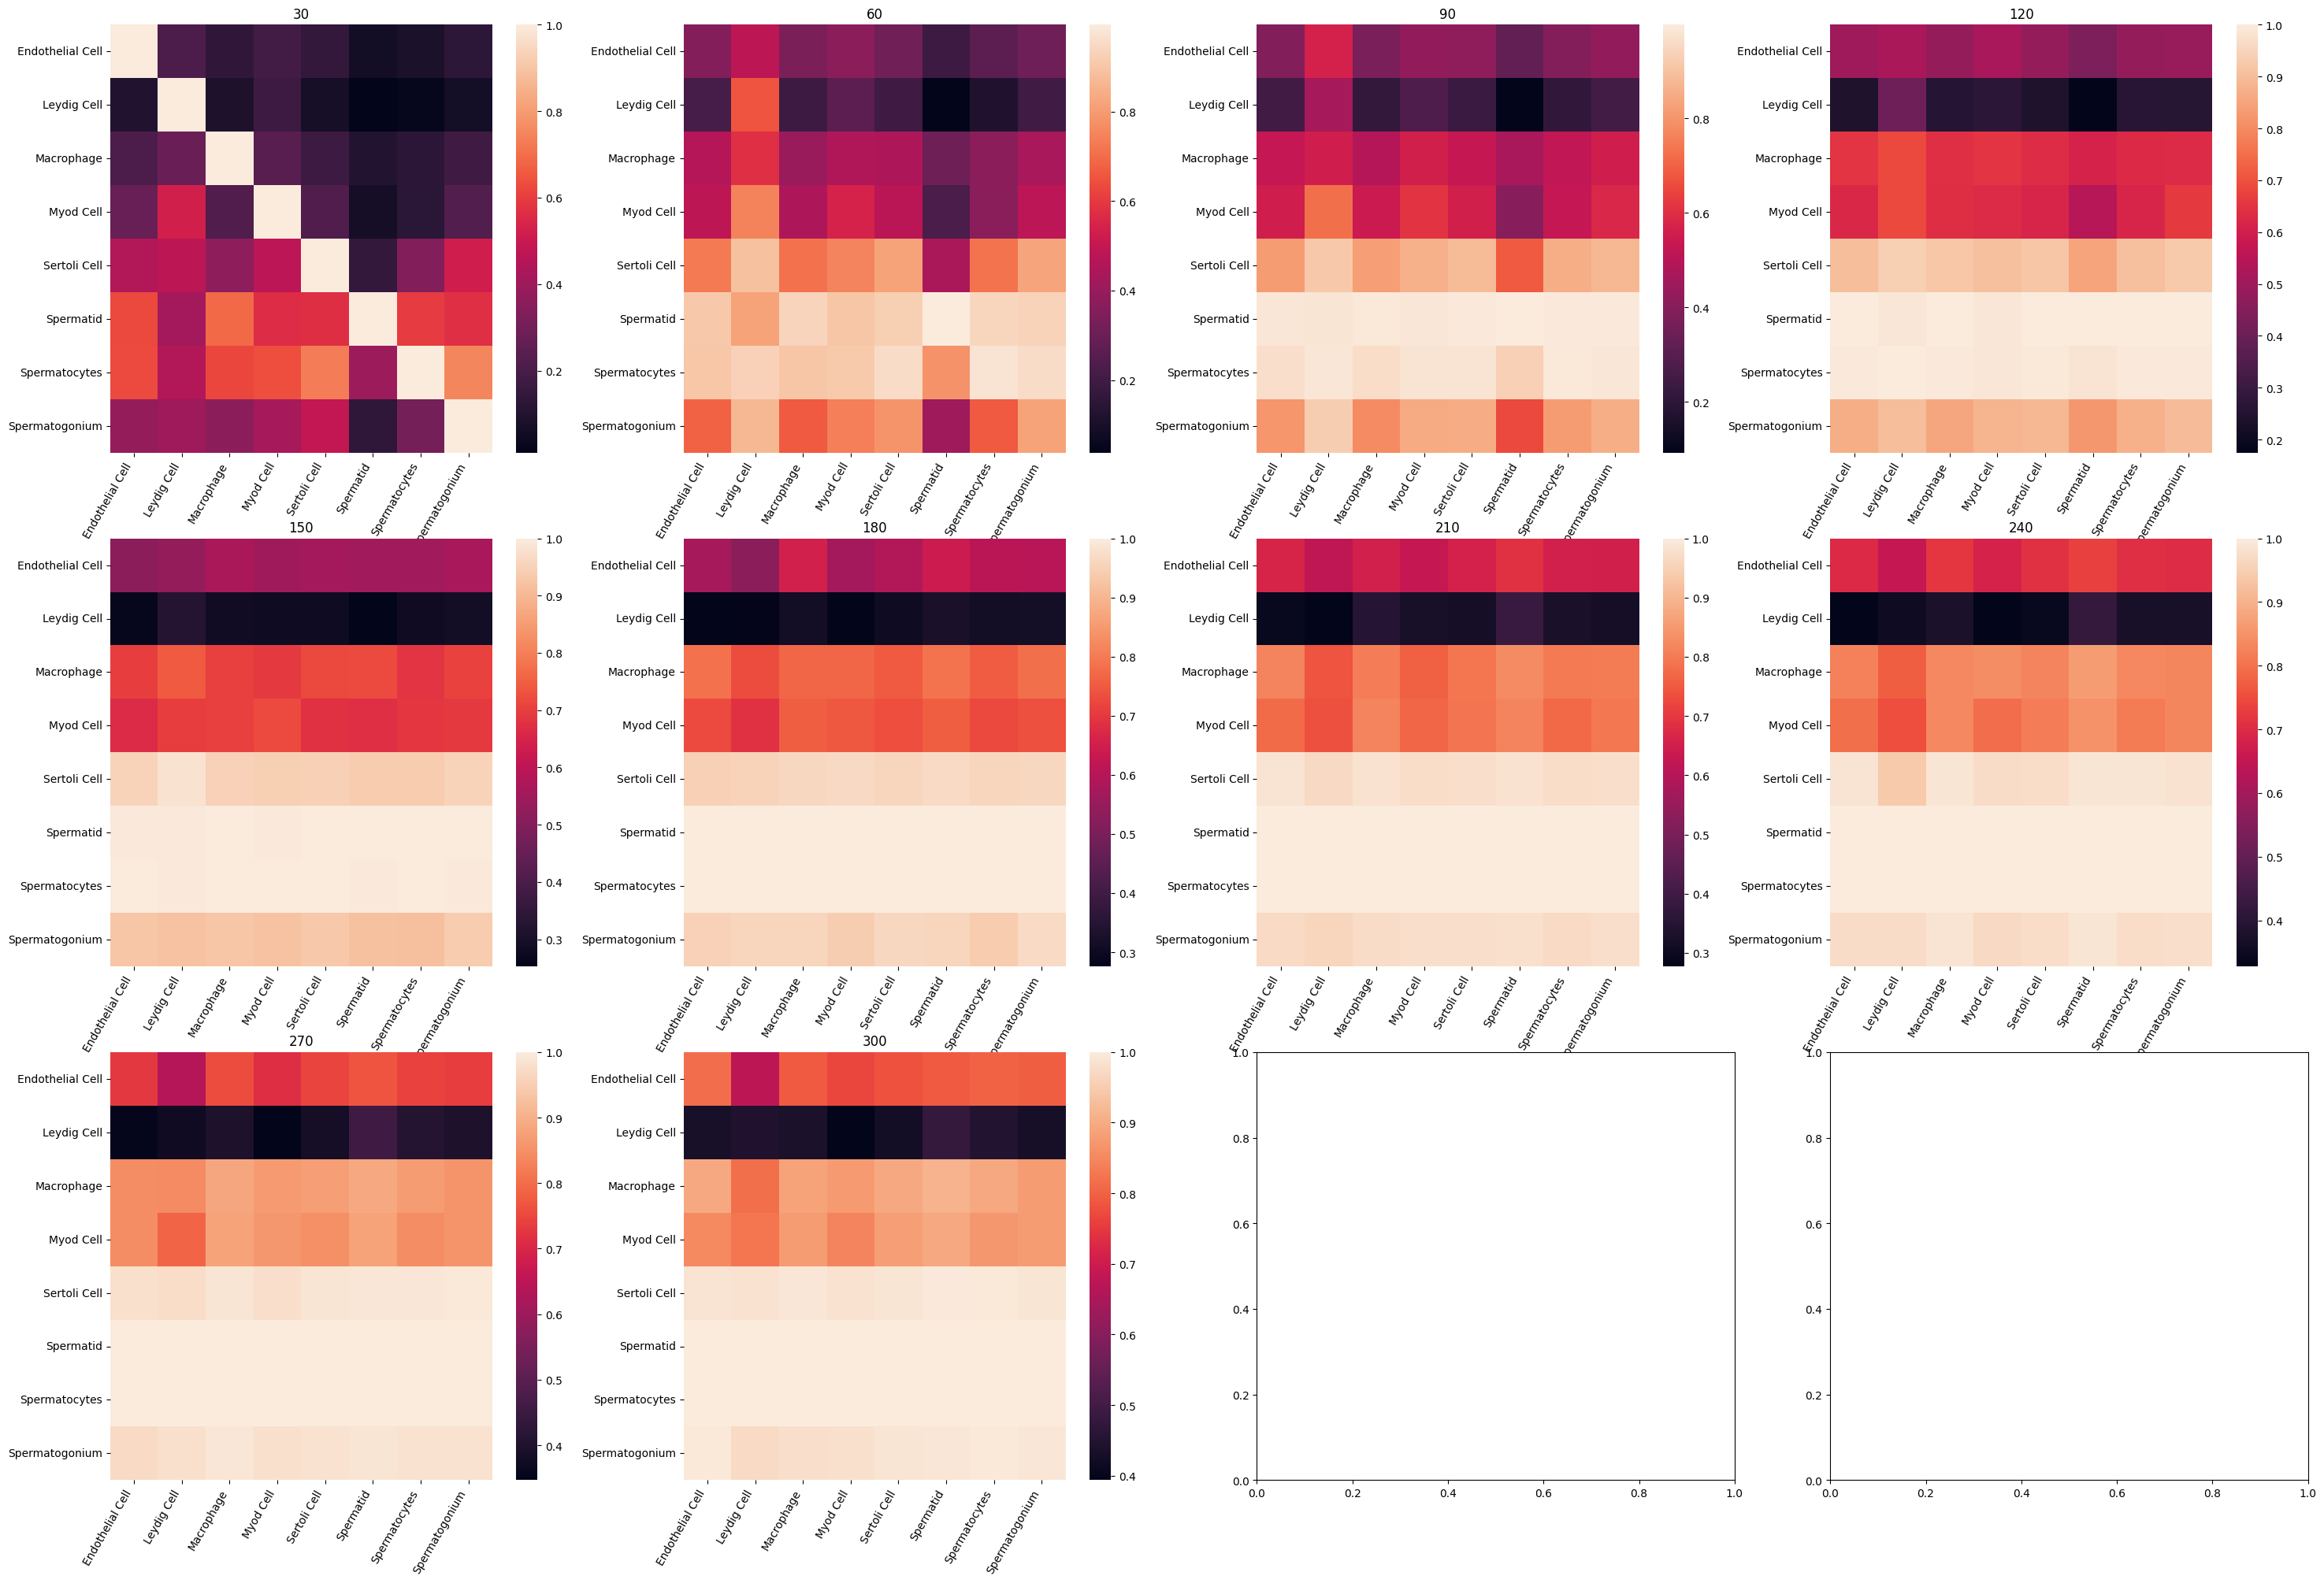

In [8]:
co_occurrence(adata_wt, use_col='celltype')
co_occurrence_heatmap(adata_wt, use_col='celltype', use_key ='co-occur_our')

## query BRICK to find cells with spatial relationship

In [19]:
cell_list = ['Spermatid', 'Endothelial Cell', 'Leydig Cell', 
             'Macrophage', 'Myod Cell', 'Spermatid',  
             'Sertoli Cell', 'Spermatocytes', 'Spermatogonium']

nxg = BRICK.qr.query_relation(source_entity_set=cell_list, 
                              relation=['spatially_related_to', 'is_a'], 
                              multi_hop=1, source_entity_type='Cell')
nxg

""


In [21]:
nt = BRICK.pl.interact_visualize_network(nxg, save='spatial.html')
nt.show('spatial.html')

spatial.html
spatial.html


## Discover co-occurrence of Leydig Cell, Sertoli Cell and Spermatogonium

1 1


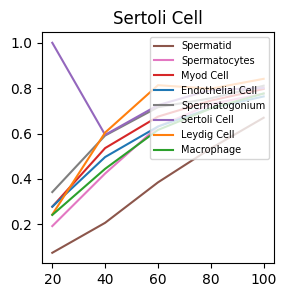

In [47]:
fig = co_occurrence_plot(adata_wt, use_col='celltype', groups=['Sertoli Cell'], use_key = 'co-occur_our')

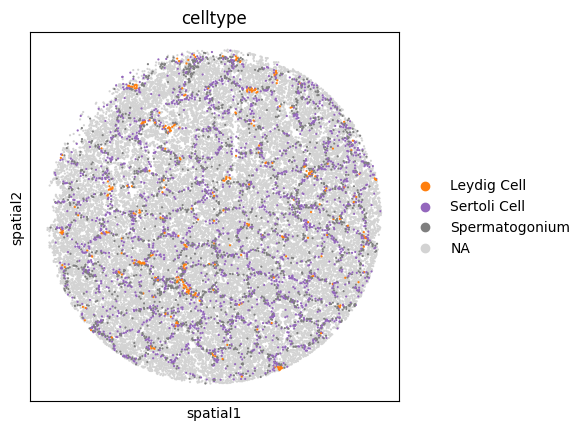

In [44]:
sc.pl.spatial(adata_wt, color = 'celltype', groups = ['Spermatogonium', 'Sertoli Cell', 'Leydig Cell'] ,spot_size = 30)

1 1


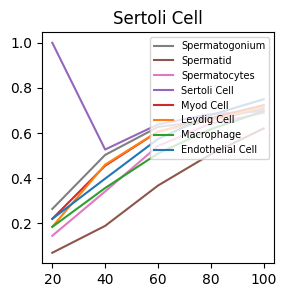

In [48]:
fig = co_occurrence_plot(adata_di, use_col='celltype', groups=['Sertoli Cell'], use_key = 'co-occur_our')

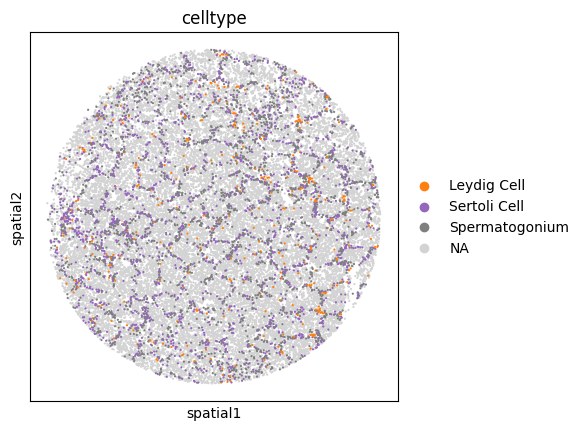

In [43]:
sc.pl.spatial(adata_di, color = 'celltype', groups = ['Spermatogonium', 'Sertoli Cell', 'Leydig Cell'] ,spot_size = 30)